# Spain Electricity Shortfall Model

The supply of electricity plays a large role in the livelihood of citizens in a country. Electricity, amongst other things, helps us stay connected, keep warm, and feed our families. Therefore there's a need to keep the lights on in order to maintain and improve the standard of living by investing in electricity infrastructure. However, in recent years, there has been evidence that the use of purely non-renewable sources is not sustainable.

The government of Spain is considering an expansion of it's renewable energy resource infrastructure investments. As such, they require information on the trends and patterns of the countries renewable sources and fossil fuel energy generation. 

The aim of this project is to model the shortfall between the energy generated by means of fossil fuels and various renewable sources for the country of Spain. This will help determine if it is the wise decision for Spain to invest further into renewable energy resources.

The target variable is the 'daily-load-shortfall' which will be modelled against various weather features such as wind speed, pressure, humidity etc.


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd                    
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Libraries for data preparation
from statsmodels.graphics.correlation import plot_corr  
from sklearn.impute import KNNImputer                   
from sklearn.preprocessing import StandardScaler        

# Libraries for Model Building
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import LinearRegression       
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV        
import xgboost as xgb                                   

# Libraries for calculating performance metrics
from sklearn import metrics                             
from sklearn.metrics import r2_score

# Libraries to Save/Restore Models
import pickle

# Setting global constants to ensure notebook results are reproducible
test_size=0.2, 
shuffle=False, 
random_state=123  

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [2]:
# Load the data
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv', index_col=0)

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In this section we perform an in-depth analysis of all the variables in the DataFrame.

In [3]:
#view dataset
df_train.head()

,Unnamed: 0,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
0,0,2015-01-01 03:00:00,0.666667,level_5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,...,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
1,1,2015-01-01 06:00:00,0.333333,level_10,0.0,1.666667,78.333333,64.666667,0.0,1.000000,...,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2,2,2015-01-01 09:00:00,1.000000,level_9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,...,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
3,3,2015-01-01 12:00:00,1.000000,level_8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,...,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
4,4,2015-01-01 15:00:00,1.000000,level_7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,...,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667


The feature we are predicting is **load_shortfall_3h** which is the difference or shortfall between energy generated by means of fossil fuels and various renewable sources. The first column 'Unnamed' is irrelevant so we drop it.

In [4]:
#Drop first column
df_train = df_train.drop('Unnamed: 0', axis=1)

In [5]:
#Shape of the dataset
print('Train dataset : ', df_train.shape)
print('Test dataset : ', df_test.shape)

Train dataset :  (8763, 48)
Test dataset :  (2920, 47)


The train dataset has 8763 rows and 48 columns. The test dataset has 2920 rows and 47 columns (excluding the target variable).

In [6]:
# look at data statistics
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  8763 non-null   object 
 1   Madrid_wind_speed     8763 non-null   float64
 2   Valencia_wind_deg     8763 non-null   object 
 3   Bilbao_rain_1h        8763 non-null   float64
 4   Valencia_wind_speed   8763 non-null   float64
 5   Seville_humidity      8763 non-null   float64
 6   Madrid_humidity       8763 non-null   float64
 7   Bilbao_clouds_all     8763 non-null   float64
 8   Bilbao_wind_speed     8763 non-null   float64
 9   Seville_clouds_all    8763 non-null   float64
 10  Bilbao_wind_deg       8763 non-null   float64
 11  Barcelona_wind_speed  8763 non-null   float64
 12  Barcelona_wind_deg    8763 non-null   float64
 13  Madrid_clouds_all     8763 non-null   float64
 14  Seville_wind_speed    8763 non-null   float64
 15  Barcelona_rain_1h    

The dataset has 48 features, of which 3 are `categorical` (time, Valencia_wind_deg and Seville_pressure) and the rest are `numerical features`. We will have to convert Valencia_wind_deg and Seville_pressure to numerical features and time feature to `datetime64`. We can also observe that we have a relatively small dataset that comprises of 8762 samples and occupying a total of ~3.2+ MB of memory. We also observe that `Valencia_pressure` has **2068** missing values. We will have to decide if we want to drop this column or impute the missing values.

In [7]:
df_train['Valencia_pressure'].isnull().sum()

2068

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2920 entries, 8763 to 11682
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  2920 non-null   object 
 1   Madrid_wind_speed     2920 non-null   float64
 2   Valencia_wind_deg     2920 non-null   object 
 3   Bilbao_rain_1h        2920 non-null   float64
 4   Valencia_wind_speed   2920 non-null   float64
 5   Seville_humidity      2920 non-null   float64
 6   Madrid_humidity       2920 non-null   float64
 7   Bilbao_clouds_all     2920 non-null   float64
 8   Bilbao_wind_speed     2920 non-null   float64
 9   Seville_clouds_all    2920 non-null   float64
 10  Bilbao_wind_deg       2920 non-null   float64
 11  Barcelona_wind_speed  2920 non-null   float64
 12  Barcelona_wind_deg    2920 non-null   float64
 13  Madrid_clouds_all     2920 non-null   float64
 14  Seville_wind_speed    2920 non-null   float64
 15  Barcelona_rain_1h     

In [9]:
df_test['Valencia_pressure'].isnull().sum()

454

`Valencia_pressure` has 454 missing values in the test data.

Next we analyse the 5 statistic summary of all the numerical features in the dataset 

In [10]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Madrid_wind_speed,8763.0,2.425729,1.850371,0.000000,1.000000,2.000000,3.333333,1.300000e+01
Bilbao_rain_1h,8763.0,0.135753,0.374901,0.000000,0.000000,0.000000,0.100000,3.000000e+00
Valencia_wind_speed,8763.0,2.586272,2.411190,0.000000,1.000000,1.666667,3.666667,5.200000e+01
Seville_humidity,8763.0,62.658793,22.621226,8.333333,44.333333,65.666667,82.000000,1.000000e+02
Madrid_humidity,8763.0,57.414717,24.335396,6.333333,36.333333,58.000000,78.666667,1.000000e+02
Bilbao_clouds_all,8763.0,43.469132,32.551044,0.000000,10.000000,45.000000,75.000000,1.000000e+02
Bilbao_wind_speed,8763.0,1.850356,1.695888,0.000000,0.666667,1.000000,2.666667,1.266667e+01
Seville_clouds_all,8763.0,13.714748,24.272482,0.000000,0.000000,0.000000,20.000000,9.733333e+01
Bilbao_wind_deg,8763.0,158.957511,102.056299,0.000000,73.333333,147.000000,234.000000,3.593333e+02
Barcelona_wind_speed,8763.0,2.870497,1.792197,0.000000,1.666667,2.666667,4.000000,1.266667e+01


These are the insights we can observe:
- Focusing on the target variable `load_shortfall_3h`, the lowest shortfall is negative. This could mean that there could have been an event where the energy generated via renewable resources was larger than that generated via fossil fuels. It could also mean that there was an incorrect data entry.
- Cities with rain properties such as `Barcelona_rain_1h`, `Barcelona_rain_3h`, `Seville_rain_3h` mostly has null entries. This is valuable information because it means that in the past hour or 3 hours there was no rain. Hence we do not regard this as an error.
- Based on the standard deviation and means of the different features, there is high variation between the predictive features. We might have to consider standadisation to reduce outliers. This ensures our model is more robust.


And for categorical features:

In [11]:
# data statistics of categorical data
df_train.describe(include=['object']).T

,count,unique,top,freq
time,8763,8763,2015-01-01 03:00:00,1
Valencia_wind_deg,8763,10,level_1,1072
Seville_pressure,8763,25,sp13,500


- `Valencia_wind_deg` has 10 unique is categories from `level_1` to `level_10`, with `level_1` being the most frequent (1072 times).
- `Seville_pressure` has 25 categories with `sp13` being the most frequent (500 times).
- All times are unique as expected.

Let us plot our relevant features and get a better view of them. This will also highlight features that mostly have null values as observed earlier.

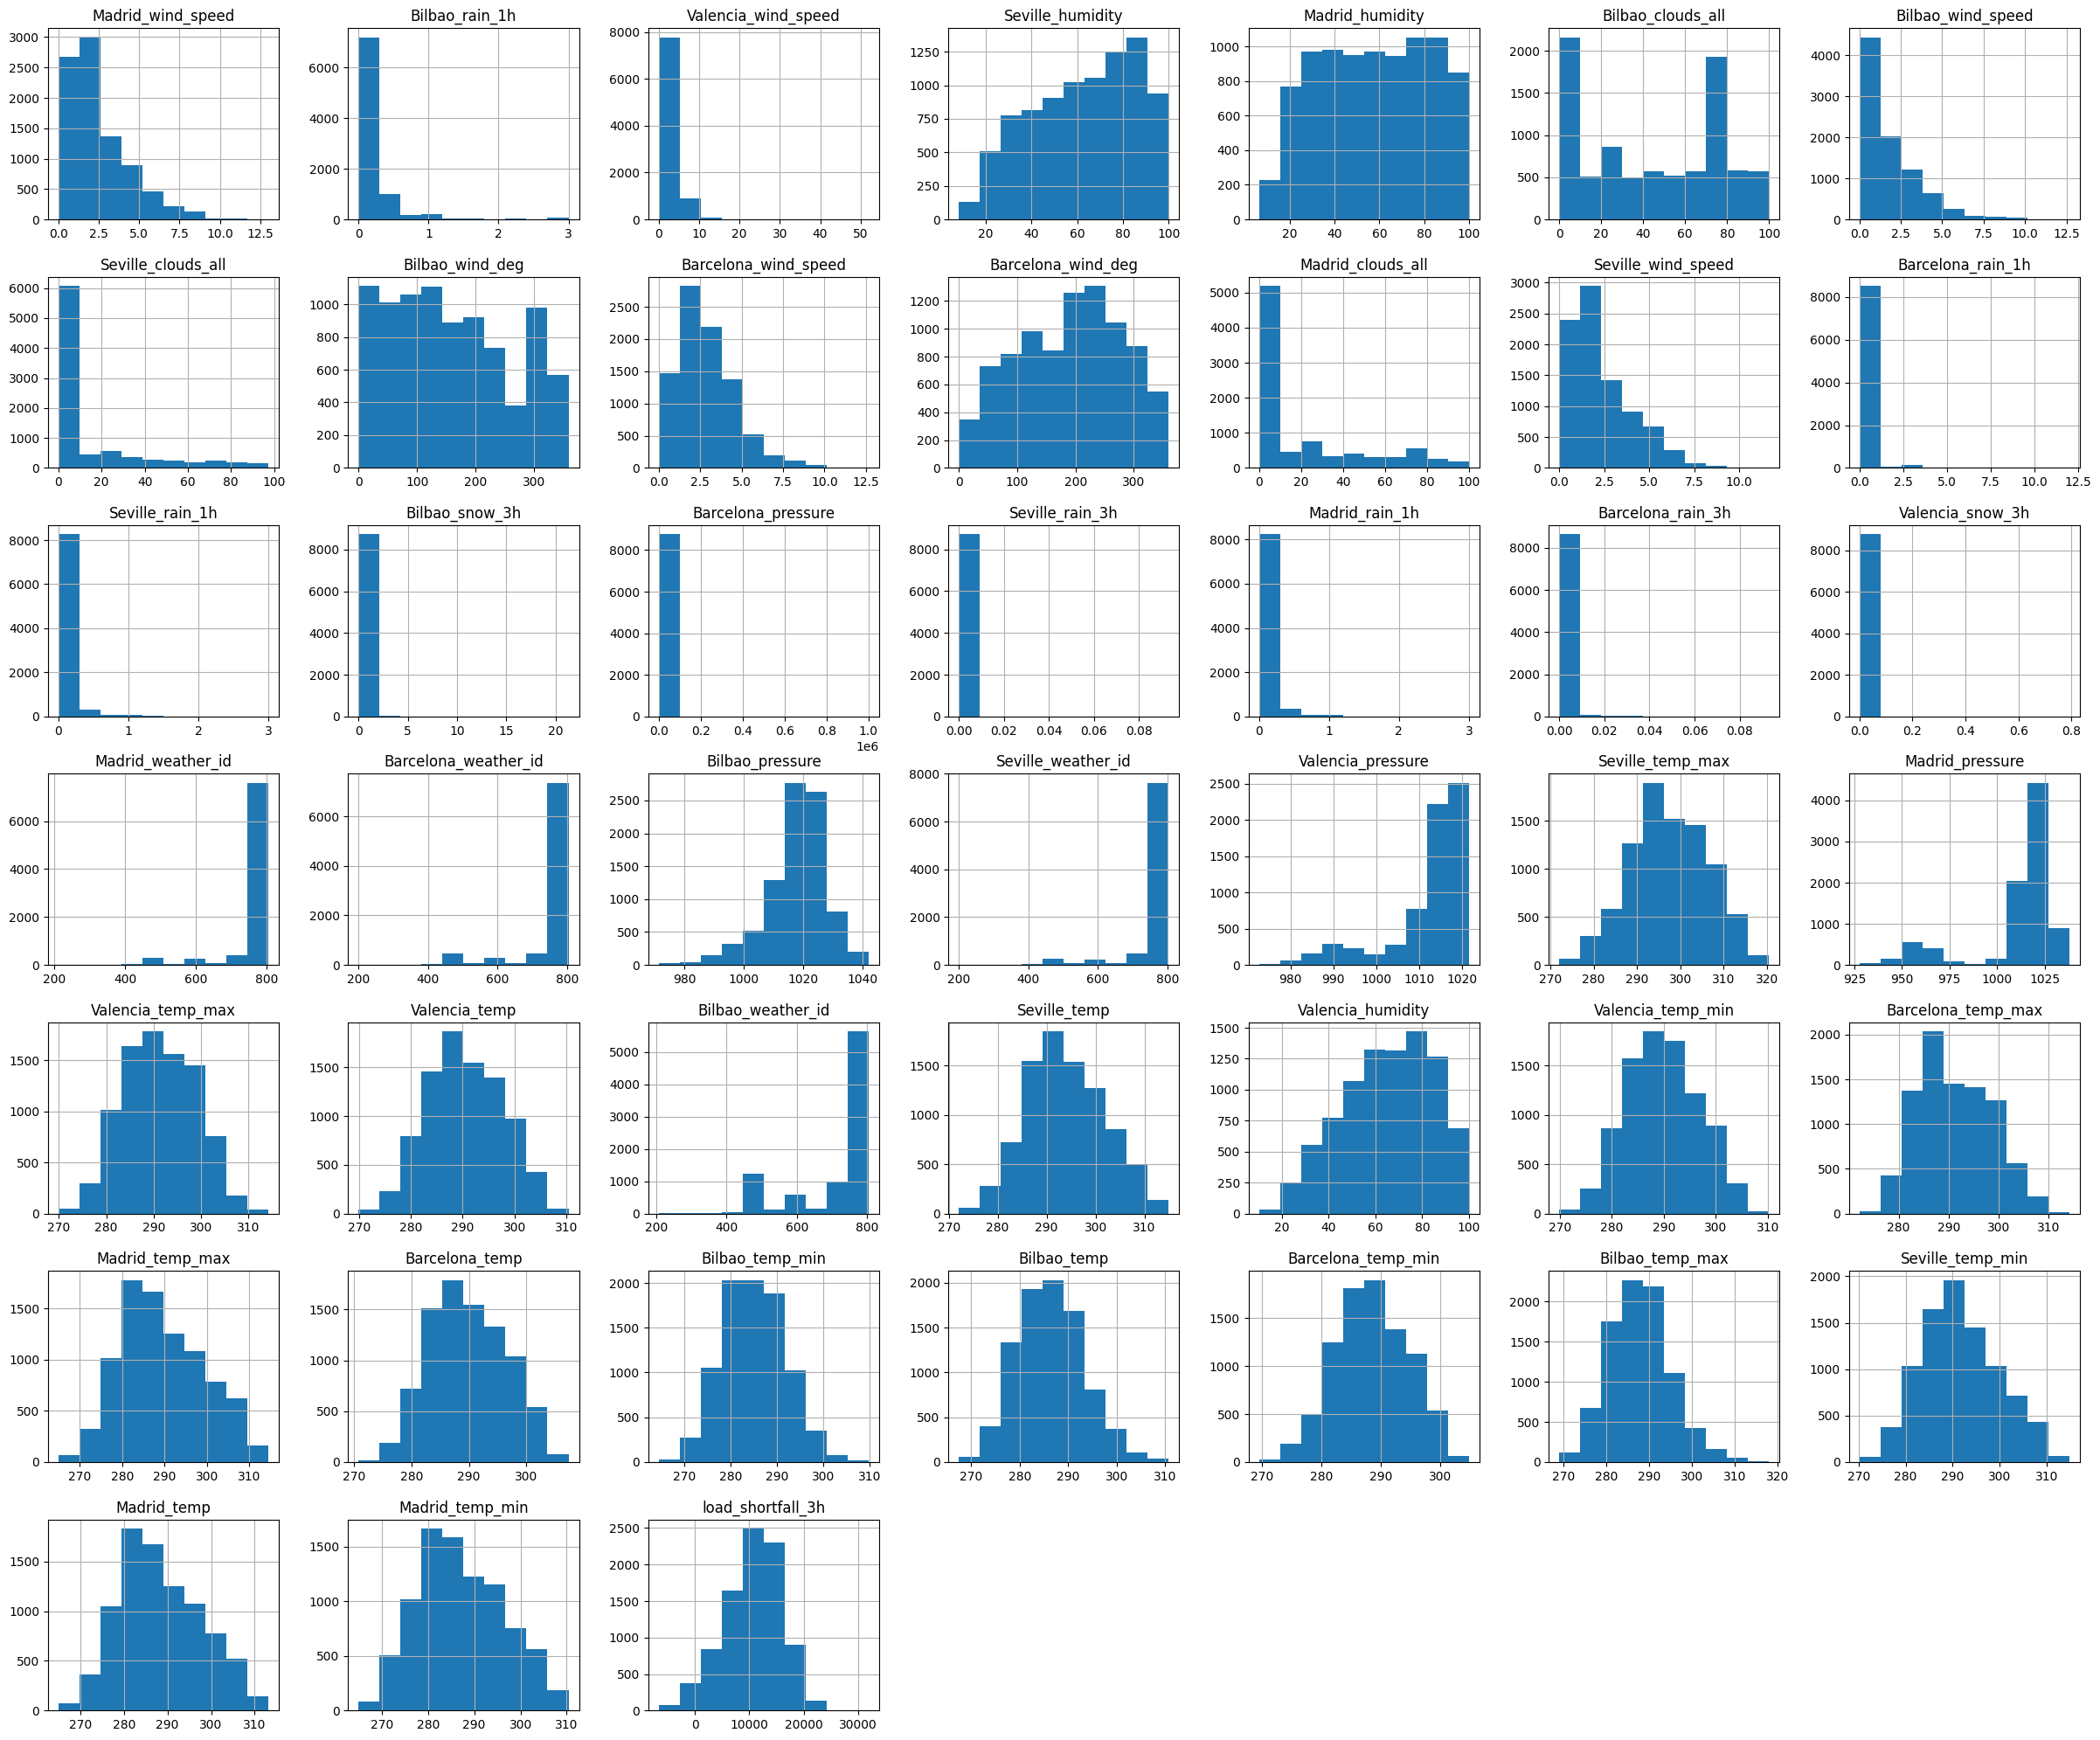

In [12]:
# feature distributions
pd.DataFrame.hist(df_train, figsize=[30,25])
plt.show()

Let's focus on the target variable:

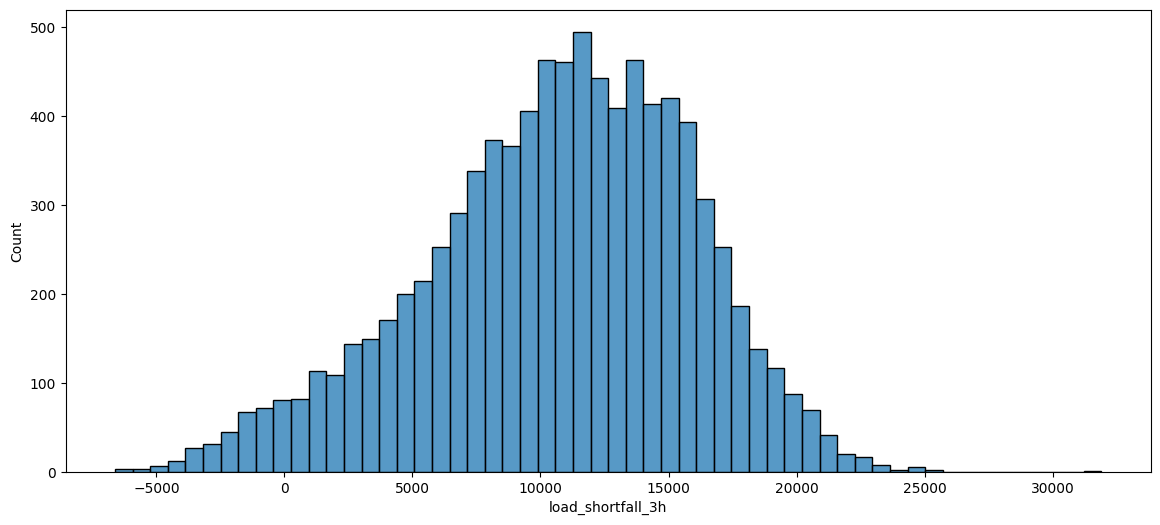

In [13]:
#target variable's distribution
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(df_train['load_shortfall_3h'])
plt.show()

- It is much clearer that the load shortfall ranges from negative to positive as observed earlier. There is high variation (~ -5000 to ~ 25000) hence we might need to scale the dataset.
- The negative shortfall mean there was no shortfall in these events - there was an adequete supply of energy generated by renewable sources compared to fossil fuels.
- The distribution of the daily load shortfall almost exhibits a normal distribution

Let's plot the target variable against dates

Text(0.5, 1.0, 'Daily load shortfall (3-hourly)')

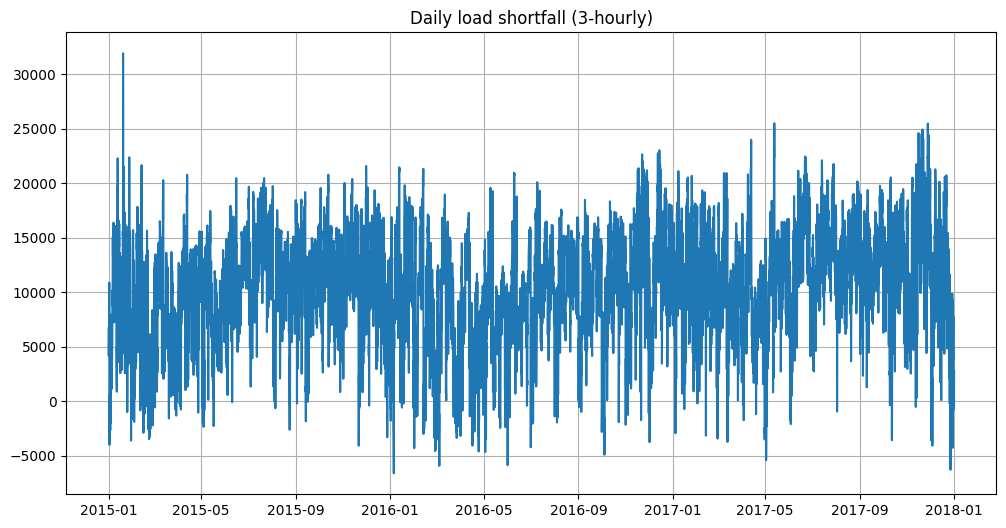

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df_train['time'].astype('datetime64[ns]'), df_train['load_shortfall_3h'])
plt.grid(True)
plt.title('Daily load shortfall (3-hourly)')

From this plot, we can see that there is some pattern emerging, even though it is not entirely clear what the pattern is. Maybe it is because we are looking at an aggregated view? Some patterns might become clearer if we analyse on a more granular level i.e. mean daily load shortfall by the hour, month, time of day, day of the year, etc.

Next let's evaluate correlation and check for any collinearity between features and target variable. First let's define numerical features.

In [15]:
num_features = df_train.drop(['Valencia_wind_deg', 'Seville_pressure', 'time'],  axis=1)

In [16]:
# evaluating the correlation between features and the target variable
correlation = num_features.corr()
correlation['load_shortfall_3h'].sort_values(ascending=False)

load_shortfall_3h       1.000000
Valencia_temp_min       0.201863
Barcelona_temp_min      0.195984
Madrid_temp             0.186036
Barcelona_temp          0.182673
Madrid_temp_max         0.182548
Bilbao_temp_max         0.180934
Bilbao_temp             0.176411
Madrid_temp_min         0.174744
Seville_temp_min        0.174718
Valencia_temp           0.173225
Bilbao_temp_min         0.172920
Barcelona_temp_max      0.164734
Seville_temp            0.159343
Bilbao_weather_id       0.145875
Valencia_temp_max       0.144270
Seville_temp_max        0.109834
Madrid_pressure         0.092638
Valencia_pressure       0.086022
Barcelona_weather_id    0.063868
Seville_weather_id      0.061104
Valencia_humidity       0.043140
Bilbao_pressure         0.039052
Madrid_weather_id       0.030868
Valencia_snow_3h       -0.021633
Barcelona_rain_3h      -0.024720
Madrid_rain_1h         -0.027159
Seville_rain_1h        -0.031572
Bilbao_snow_3h         -0.031721
Seville_rain_3h        -0.032945
Barcelona_

At first glance it seems the features have low colleration to the target variable. Now let us analyse if there is any collinearity between the features themselves. 

<Axes: >

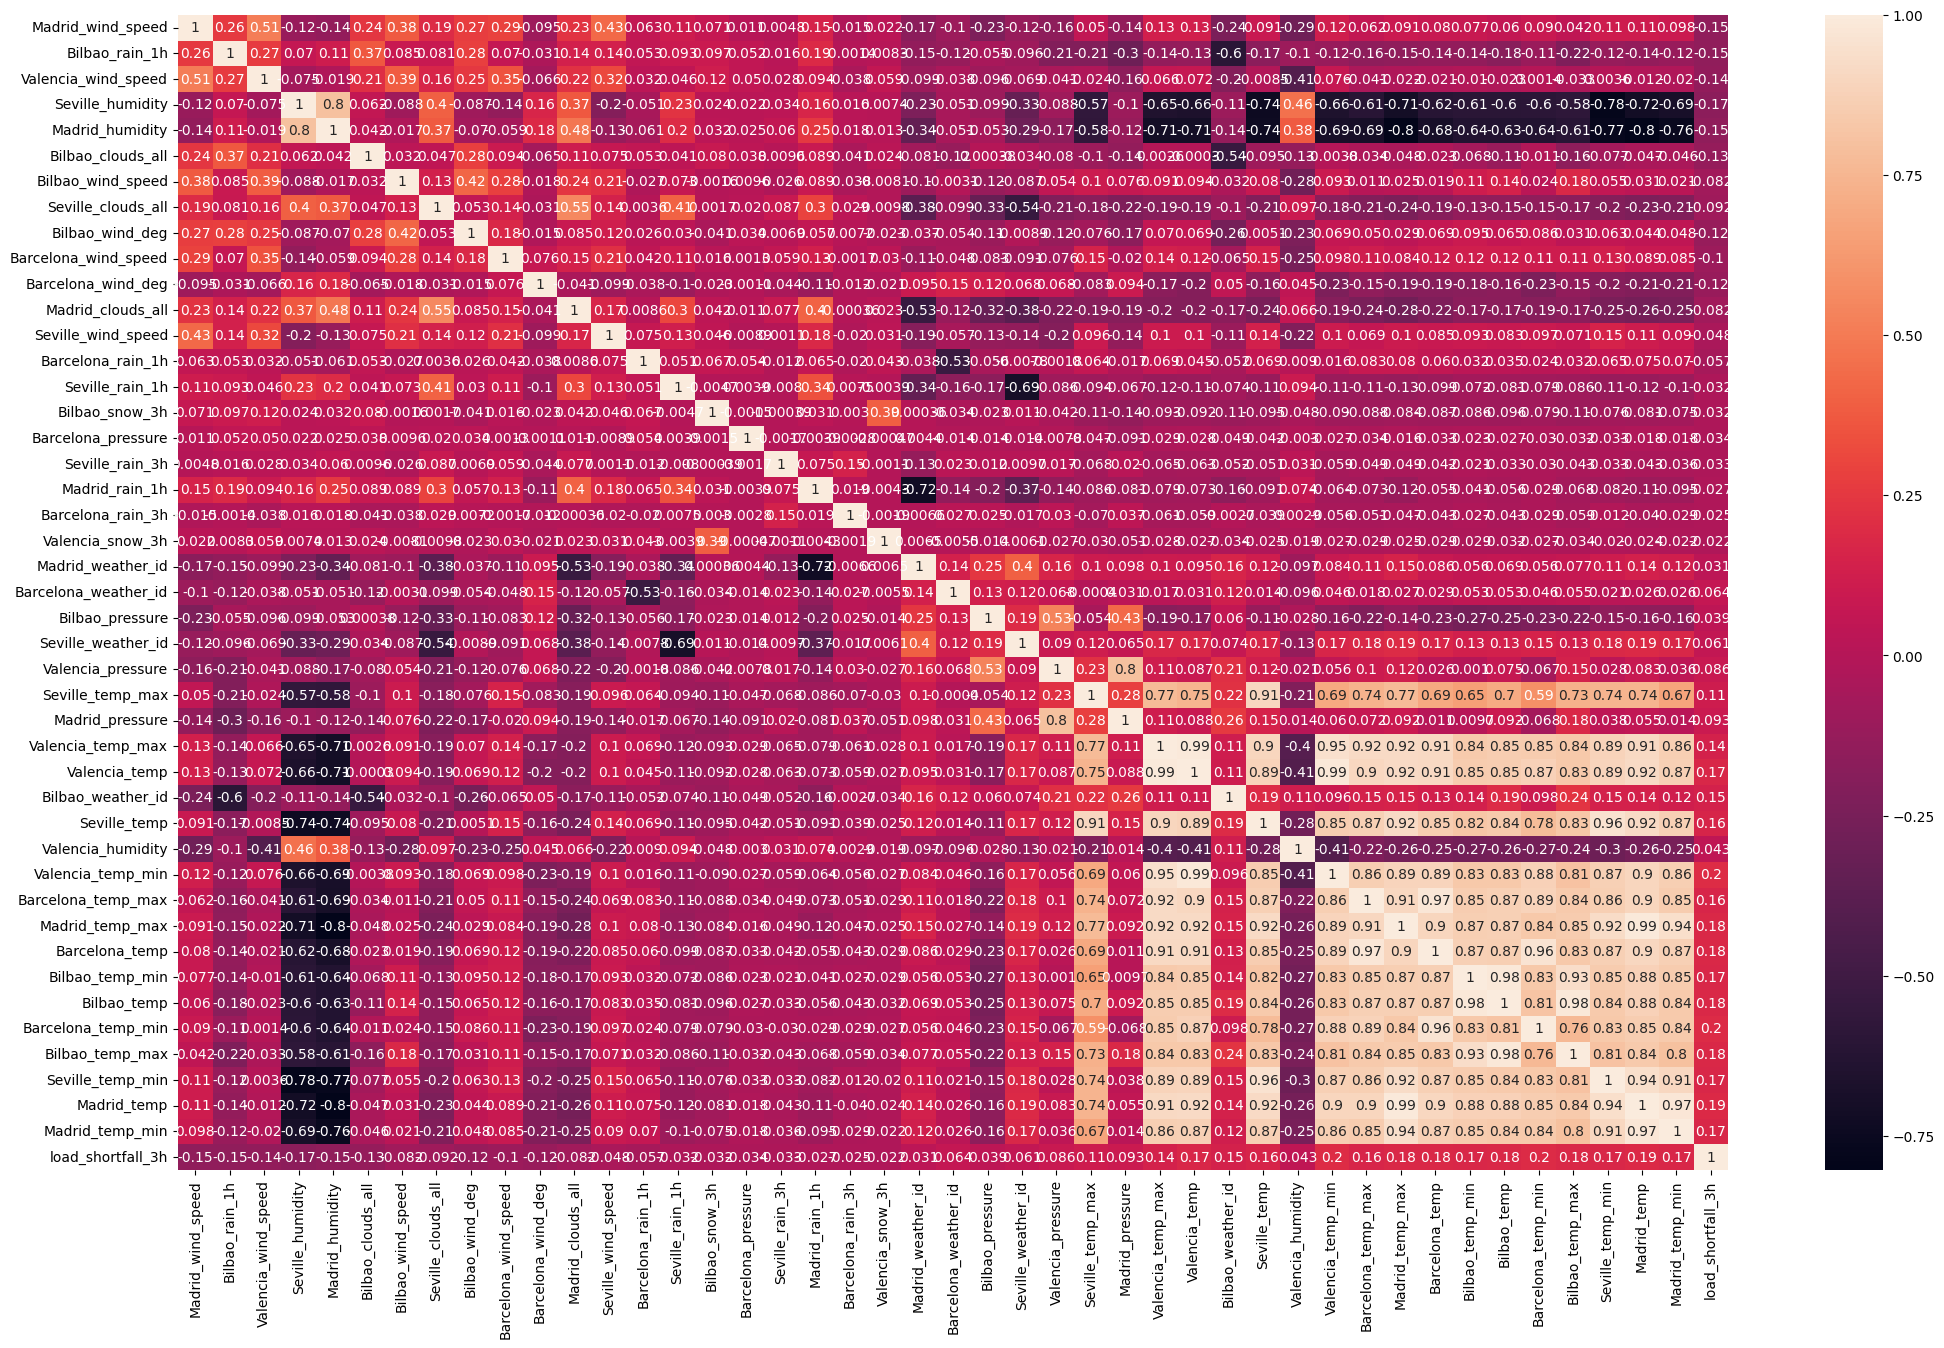

In [17]:
plt.figure(figsize=(25,15))
sns.heatmap(num_features.corr(), annot = True)

Lets limit the values to only greater than 85%.

In [18]:
num_features.corr('pearson') 
#correlations_ 
cor_85 = num_features.corr()[np.abs(num_features.corr()) > 0.85]        
cor_85

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
Madrid_wind_speed,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bilbao_rain_1h,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Valencia_wind_speed,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seville_humidity,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Madrid_humidity,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bilbao_clouds_all,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bilbao_wind_speed,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seville_clouds_all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bilbao_wind_deg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barcelona_wind_speed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


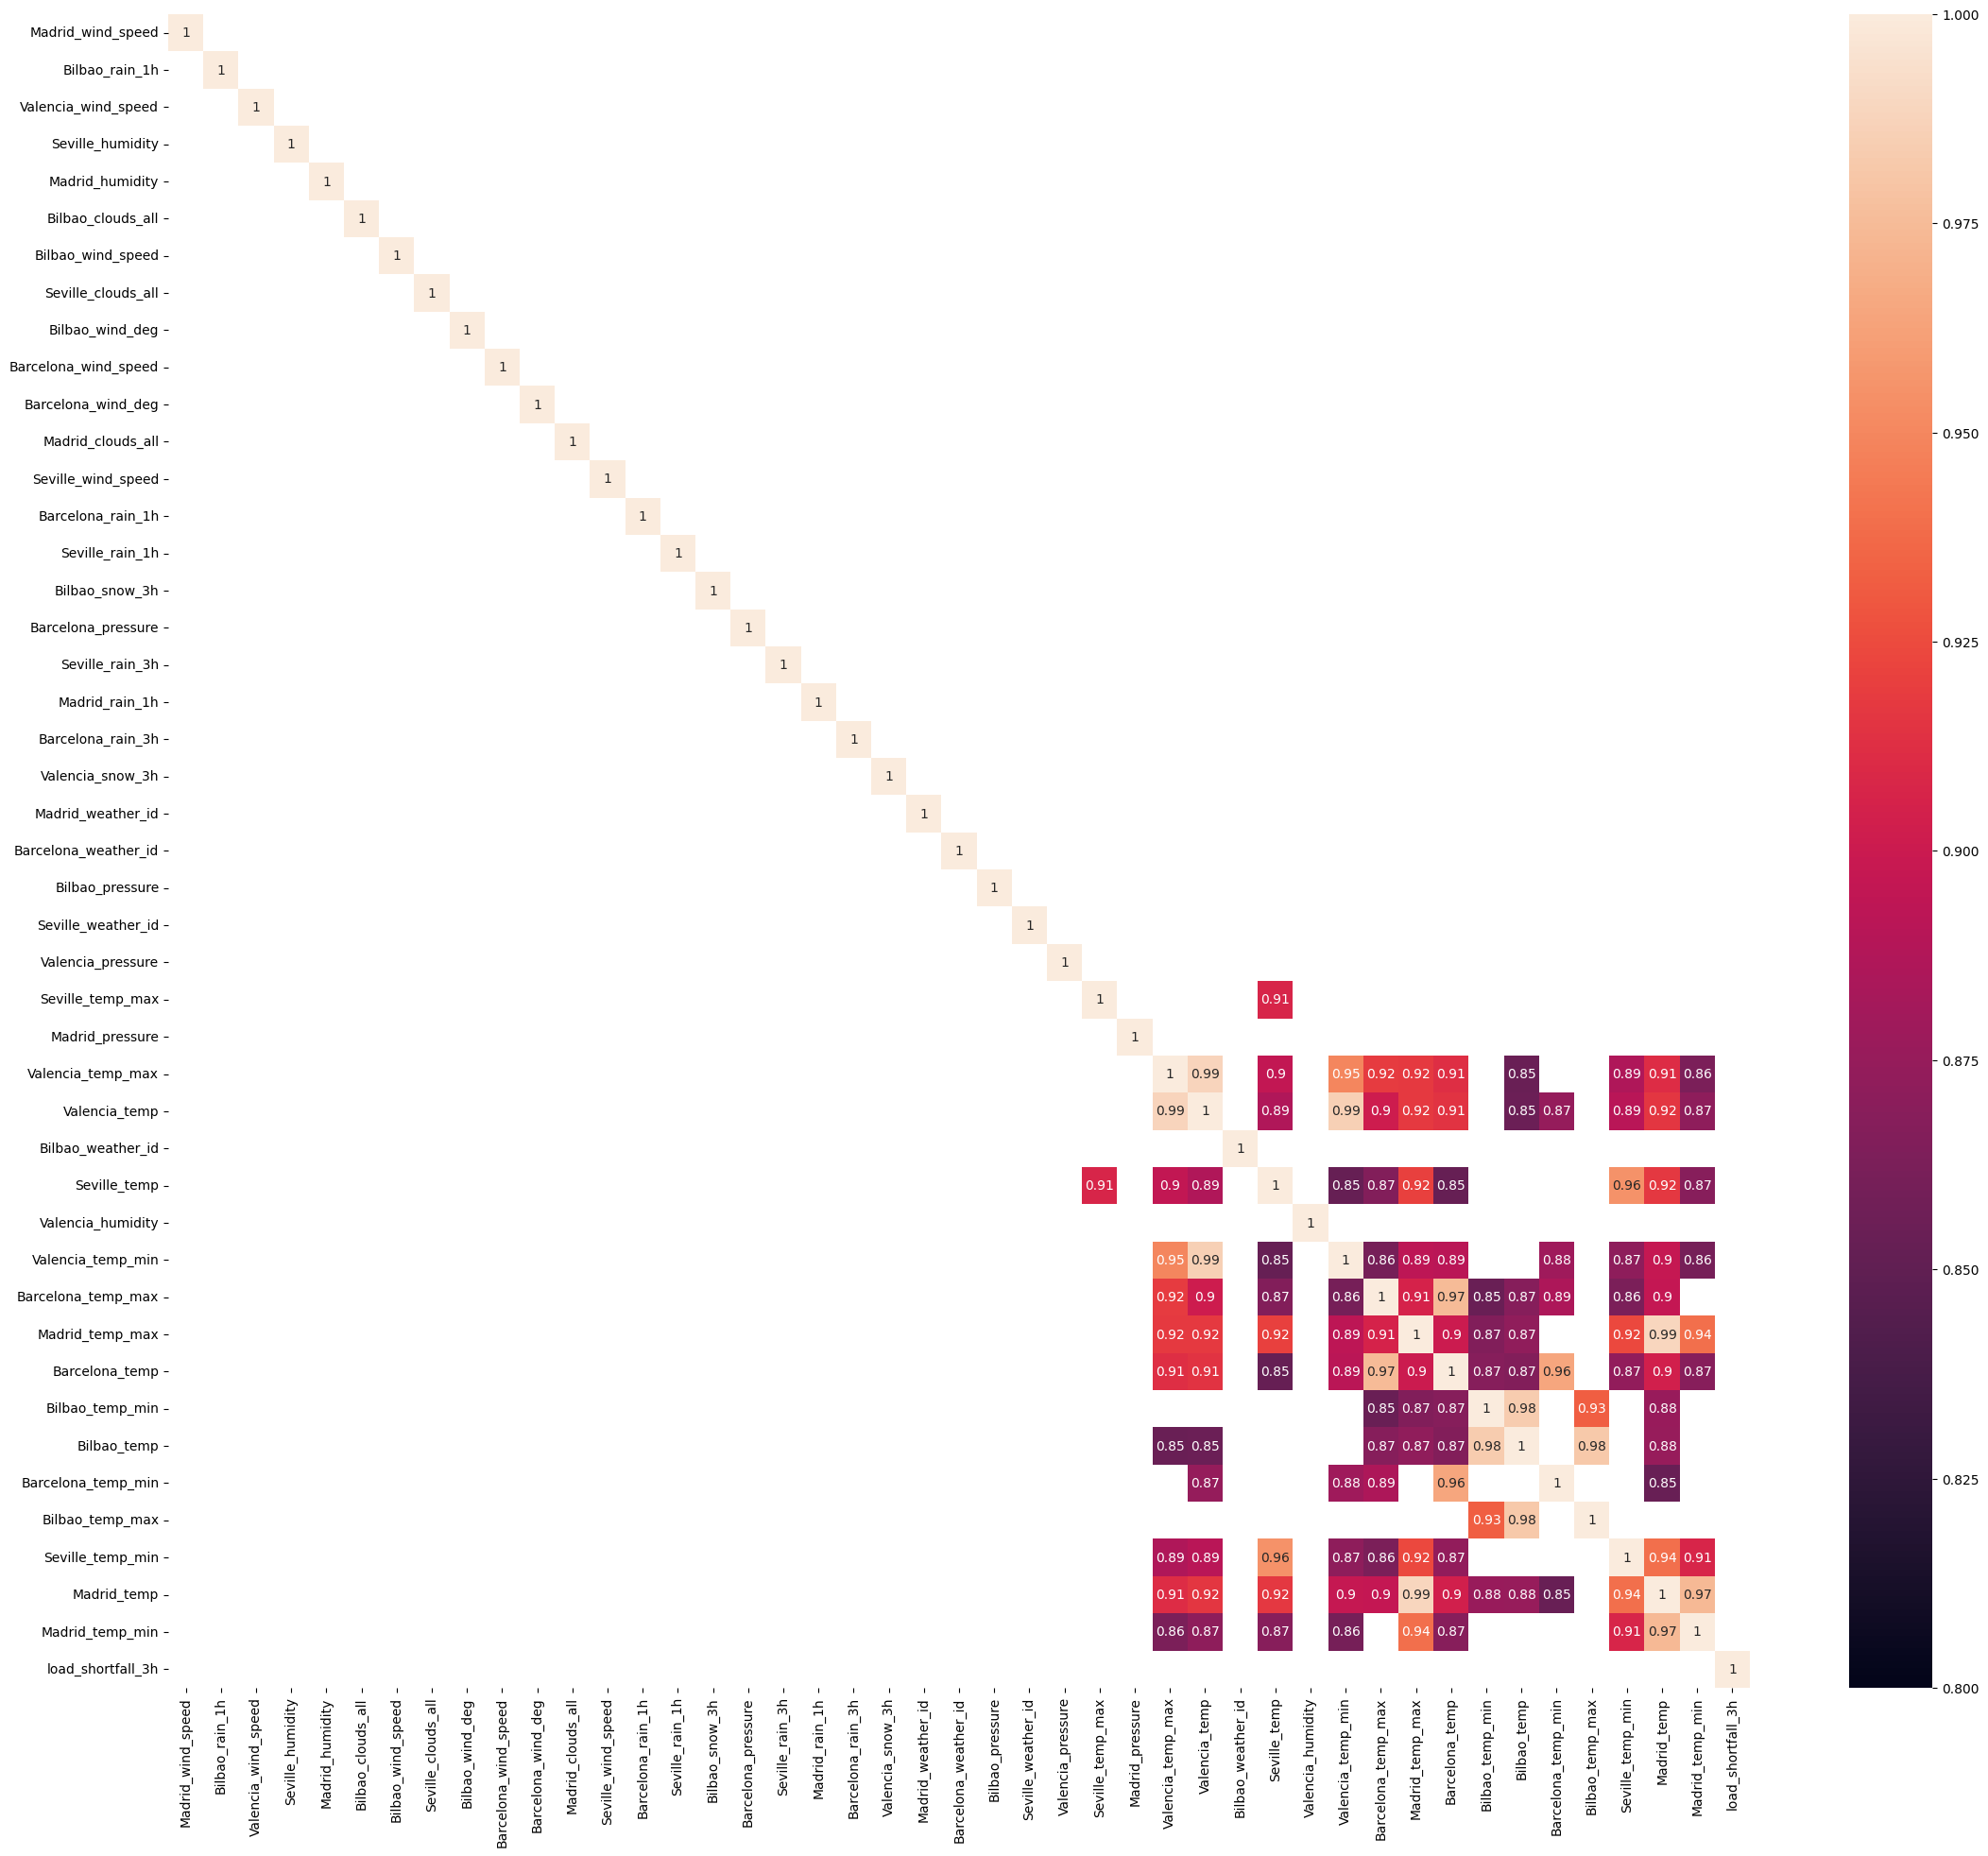

In [19]:
plt.figure(figsize=(27, 23))
heatmap = sns.heatmap(cor_85, vmin=0.8, vmax=1, annot=True)

Analysis:
There are features that show high collinearity and as such we need to perform feature selection. Keeping collinear features will cause unreliability with our model's predictions. Looks like we might have to drop the temperature features from all cities.

<a id="four"></a>
## 4. Feature Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Let us first convert the `time` feature from object to datetime datatype

In [20]:
df_train['time'] = pd.to_datetime(df_train['time'])

In [21]:
# create new temporal features 
df_train['weekday'] = df_train['time'].dt.weekday                                      #Day of the week
df_train['day_of_year'] = df_train['time'].dt.dayofyear                                       #Day of the year
df_train['month'] = pd.DatetimeIndex(df_train['time']).month                          #Month
df_train['year'] = pd.DatetimeIndex(df_train['time']).year                                    #Year
df_train['day_of_month'] = pd.DatetimeIndex(df_train['time']).day                             #Day of month
df_train['hour_of_day'] = pd.DatetimeIndex(df_train['time']).hour                             #Hour of day
df_train['hour_of_year'] = (df_train['time'].dt.dayofyear )* 24 + df_train['time'].dt.hour    #Hour of year 
df_train['hour_of_week'] = (df_train['time'].dt.dayofweek ) * 24 +  df_train['time'].dt.hour  #Hour of week
#df_train = df_train.drop('time', axis=1)
df_train.head()

,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,...,Madrid_temp_min,load_shortfall_3h,weekday,day_of_year,month,year,day_of_month,hour_of_day,hour_of_year,hour_of_week
0,2015-01-01 03:00:00,0.666667,level_5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,...,265.938000,6715.666667,3,1,1,2015,1,3,27,75
1,2015-01-01 06:00:00,0.333333,level_10,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,...,266.386667,4171.666667,3,1,1,2015,1,6,30,78
2,2015-01-01 09:00:00,1.000000,level_9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,...,272.708667,4274.666667,3,1,1,2015,1,9,33,81
3,2015-01-01 12:00:00,1.000000,level_8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,...,281.895219,5075.666667,3,1,1,2015,1,12,36,84
4,2015-01-01 15:00:00,1.000000,level_7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,...,280.678437,6620.666667,3,1,1,2015,1,15,39,87


Let's check correllation of these features against target variables and each other.

<Axes: >

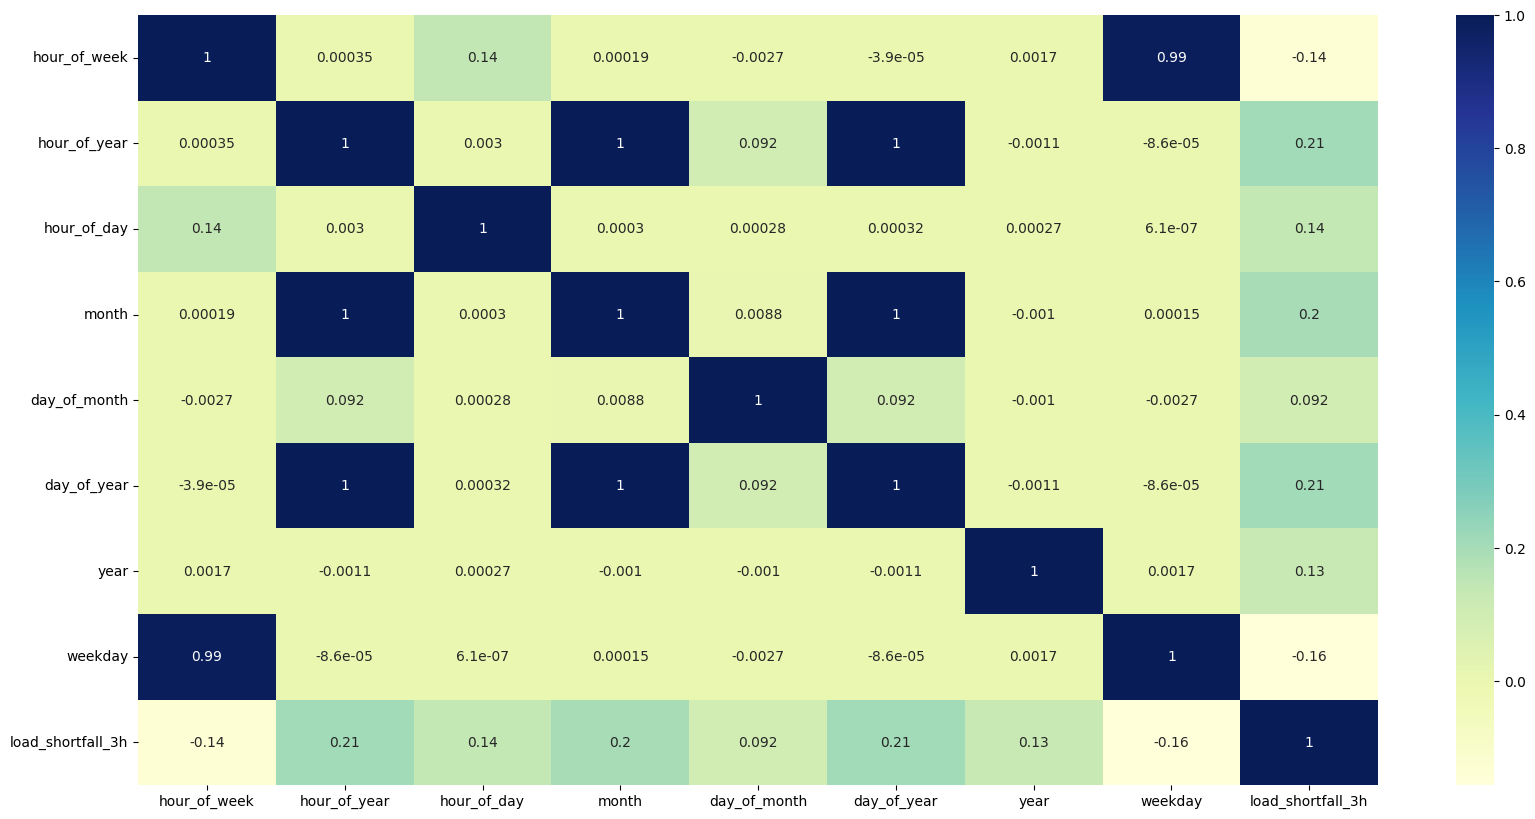

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train[["hour_of_week", "hour_of_year", "hour_of_day", "month", "day_of_month", "day_of_year", "year", "weekday", "load_shortfall_3h"]].corr(), annot = True, cmap="YlGnBu")

Looks like there is multicollinearity between the features. We will have to drop these features: `weekday`, `month`, `year`, `hour_of_year`.


## Categorical variable encoding

Categorical variables are one-hot-encoded with the use of Pandas `.get_dummies` method. We specify only the categorical variables in the columns argument that we would like to encode i.e. the `Valencia_wind_deg`, `Seville_pressure` features.

The dataframe `df` is created as a copy of the `df_train` dataset, with the newly engineered features.

In [23]:
# selecting and creating the dummy variables for the categorical features
cat_var = df_train[['Valencia_wind_deg', 'Seville_pressure']]
cat_var_dum = pd.get_dummies(cat_var, drop_first=True)
cat_var_dum.head()

,Valencia_wind_deg_level_10,Valencia_wind_deg_level_2,Valencia_wind_deg_level_3,Valencia_wind_deg_level_4,Valencia_wind_deg_level_5,Valencia_wind_deg_level_6,Valencia_wind_deg_level_7,Valencia_wind_deg_level_8,Valencia_wind_deg_level_9,Seville_pressure_sp10,...,Seville_pressure_sp23,Seville_pressure_sp24,Seville_pressure_sp25,Seville_pressure_sp3,Seville_pressure_sp4,Seville_pressure_sp5,Seville_pressure_sp6,Seville_pressure_sp7,Seville_pressure_sp8,Seville_pressure_sp9
0,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [24]:
time = df_train[['time']]

In [25]:
#copy the training data to a new dataframe
df = df_train.copy()

In [26]:
# drop the TIME column with DateTime datatype
df = df.drop(['time','Valencia_wind_deg', 'Seville_pressure'], axis=1)

In [27]:
# Create the response features and target variables
target = df['load_shortfall_3h']
df = df.drop('load_shortfall_3h', axis=1)
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Madrid_temp,Madrid_temp_min,weekday,day_of_year,month,year,day_of_month,hour_of_day,hour_of_year,hour_of_week
0,0.666667,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,223.333333,6.333333,...,265.938000,265.938000,3,1,1,2015,1,3,27,75
1,0.333333,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,221.000000,4.000000,...,266.386667,266.386667,3,1,1,2015,1,6,30,78
2,1.000000,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,214.333333,2.000000,...,272.708667,272.708667,3,1,1,2015,1,9,33,81
3,1.000000,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,199.666667,2.333333,...,281.895219,281.895219,3,1,1,2015,1,12,36,84
4,1.000000,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,185.000000,4.333333,...,280.678437,280.678437,3,1,1,2015,1,15,39,87


## Standardization

Now let's standardize the dataframe using `StandardScaler`

In [28]:
# create scaler object
scaler = StandardScaler()

# convert the scaled predictor values into a dataframe
df = pd.DataFrame(scaler.fit_transform(df),columns = df.columns)
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Madrid_temp,Madrid_temp_min,weekday,day_of_year,month,year,day_of_month,hour_of_day,hour_of_year,hour_of_week
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,-2.405393,-2.309892,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-1.090901,-1.731947,-0.157423
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,-2.357388,-2.261154,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-0.654451,-1.730761,-0.095526
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,-1.680968,-1.574407,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-0.218001,-1.729575,-0.033629
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,-0.698057,-0.576488,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,0.218449,-1.728389,0.028268
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,-0.828246,-0.708665,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,0.654899,-1.727204,0.090165


In [29]:
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Madrid_temp,Madrid_temp_min,weekday,day_of_year,month,year,day_of_month,hour_of_day,hour_of_year,hour_of_week
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,-2.405393,-2.309892,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-1.090901,-1.731947,-0.157423
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,-2.357388,-2.261154,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-0.654451,-1.730761,-0.095526
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,-1.680968,-1.574407,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-0.218001,-1.729575,-0.033629
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,-0.698057,-0.576488,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,0.218449,-1.728389,0.028268
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,-0.828246,-0.708665,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,0.654899,-1.727204,0.090165


For missing values in `Valencia_pressure` we will use K-nearest neighbours (KNN) Algorithm to impute the missing values. KNN calculates the mean of the neighbours based on the number of neighbours specified in side paramenter here we are using (6) as the number of neighbours

In [30]:
# engineer existing features
# handling missing values/ features
imputer = KNNImputer(n_neighbors=6)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [31]:
#Verify
df['Valencia_pressure'].isnull().sum()

0

In [32]:
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Madrid_temp,Madrid_temp_min,weekday,day_of_year,month,year,day_of_month,hour_of_day,hour_of_year,hour_of_week
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,-2.405393,-2.309892,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-1.090901,-1.731947,-0.157423
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,-2.357388,-2.261154,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-0.654451,-1.730761,-0.095526
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,-1.680968,-1.574407,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,-0.218001,-1.729575,-0.033629
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,-0.698057,-0.576488,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,0.218449,-1.728389,0.028268
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,-0.828246,-0.708665,-0.00274,-1.728991,-1.602429,-1.226179,-1.675368,0.654899,-1.727204,0.090165


In [33]:
# Concatenating the df with the dummy categorical df
df = pd.concat([df, cat_var_dum], axis=1)
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Seville_pressure_sp23,Seville_pressure_sp24,Seville_pressure_sp25,Seville_pressure_sp3,Seville_pressure_sp4,Seville_pressure_sp5,Seville_pressure_sp6,Seville_pressure_sp7,Seville_pressure_sp8,Seville_pressure_sp9
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,False,False,True,False,False,False,False,False,False,False
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,False,False,True,False,False,False,False,False,False,False
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,False,False,True,False,False,False,False,False,False,False
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,False,False,True,False,False,False,False,False,False,False
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,False,False,True,False,False,False,False,False,False,False


In [34]:
#Rearranging the columns
column_titles = [col for col in df.columns]
df = df.reindex(columns = column_titles)

In [35]:
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Seville_pressure_sp23,Seville_pressure_sp24,Seville_pressure_sp25,Seville_pressure_sp3,Seville_pressure_sp4,Seville_pressure_sp5,Seville_pressure_sp6,Seville_pressure_sp7,Seville_pressure_sp8,Seville_pressure_sp9
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,False,False,True,False,False,False,False,False,False,False
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,False,False,True,False,False,False,False,False,False,False
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,False,False,True,False,False,False,False,False,False,False
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,False,False,True,False,False,False,False,False,False,False
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,False,False,True,False,False,False,False,False,False,False


## Dropping some features

We discovered multicolinearity earler, let's drop all temp_max and temp_min from all the cities

In [36]:
df = df.drop(['Seville_temp_max','Valencia_temp_max','Barcelona_temp_max','Madrid_temp_max','Bilbao_temp_max','Seville_temp_min','Valencia_temp_min','Barcelona_temp_min','Madrid_temp_min','Bilbao_temp_min'],axis=1)

In [37]:
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Seville_pressure_sp23,Seville_pressure_sp24,Seville_pressure_sp25,Seville_pressure_sp3,Seville_pressure_sp4,Seville_pressure_sp5,Seville_pressure_sp6,Seville_pressure_sp7,Seville_pressure_sp8,Seville_pressure_sp9
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,False,False,True,False,False,False,False,False,False,False
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,False,False,True,False,False,False,False,False,False,False
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,False,False,True,False,False,False,False,False,False,False
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,False,False,True,False,False,False,False,False,False,False
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,False,False,True,False,False,False,False,False,False,False


Let's also drop the redundant time variables

In [38]:
df = df.drop(['weekday', 'year', 'month', 'hour_of_year'], axis=1) 

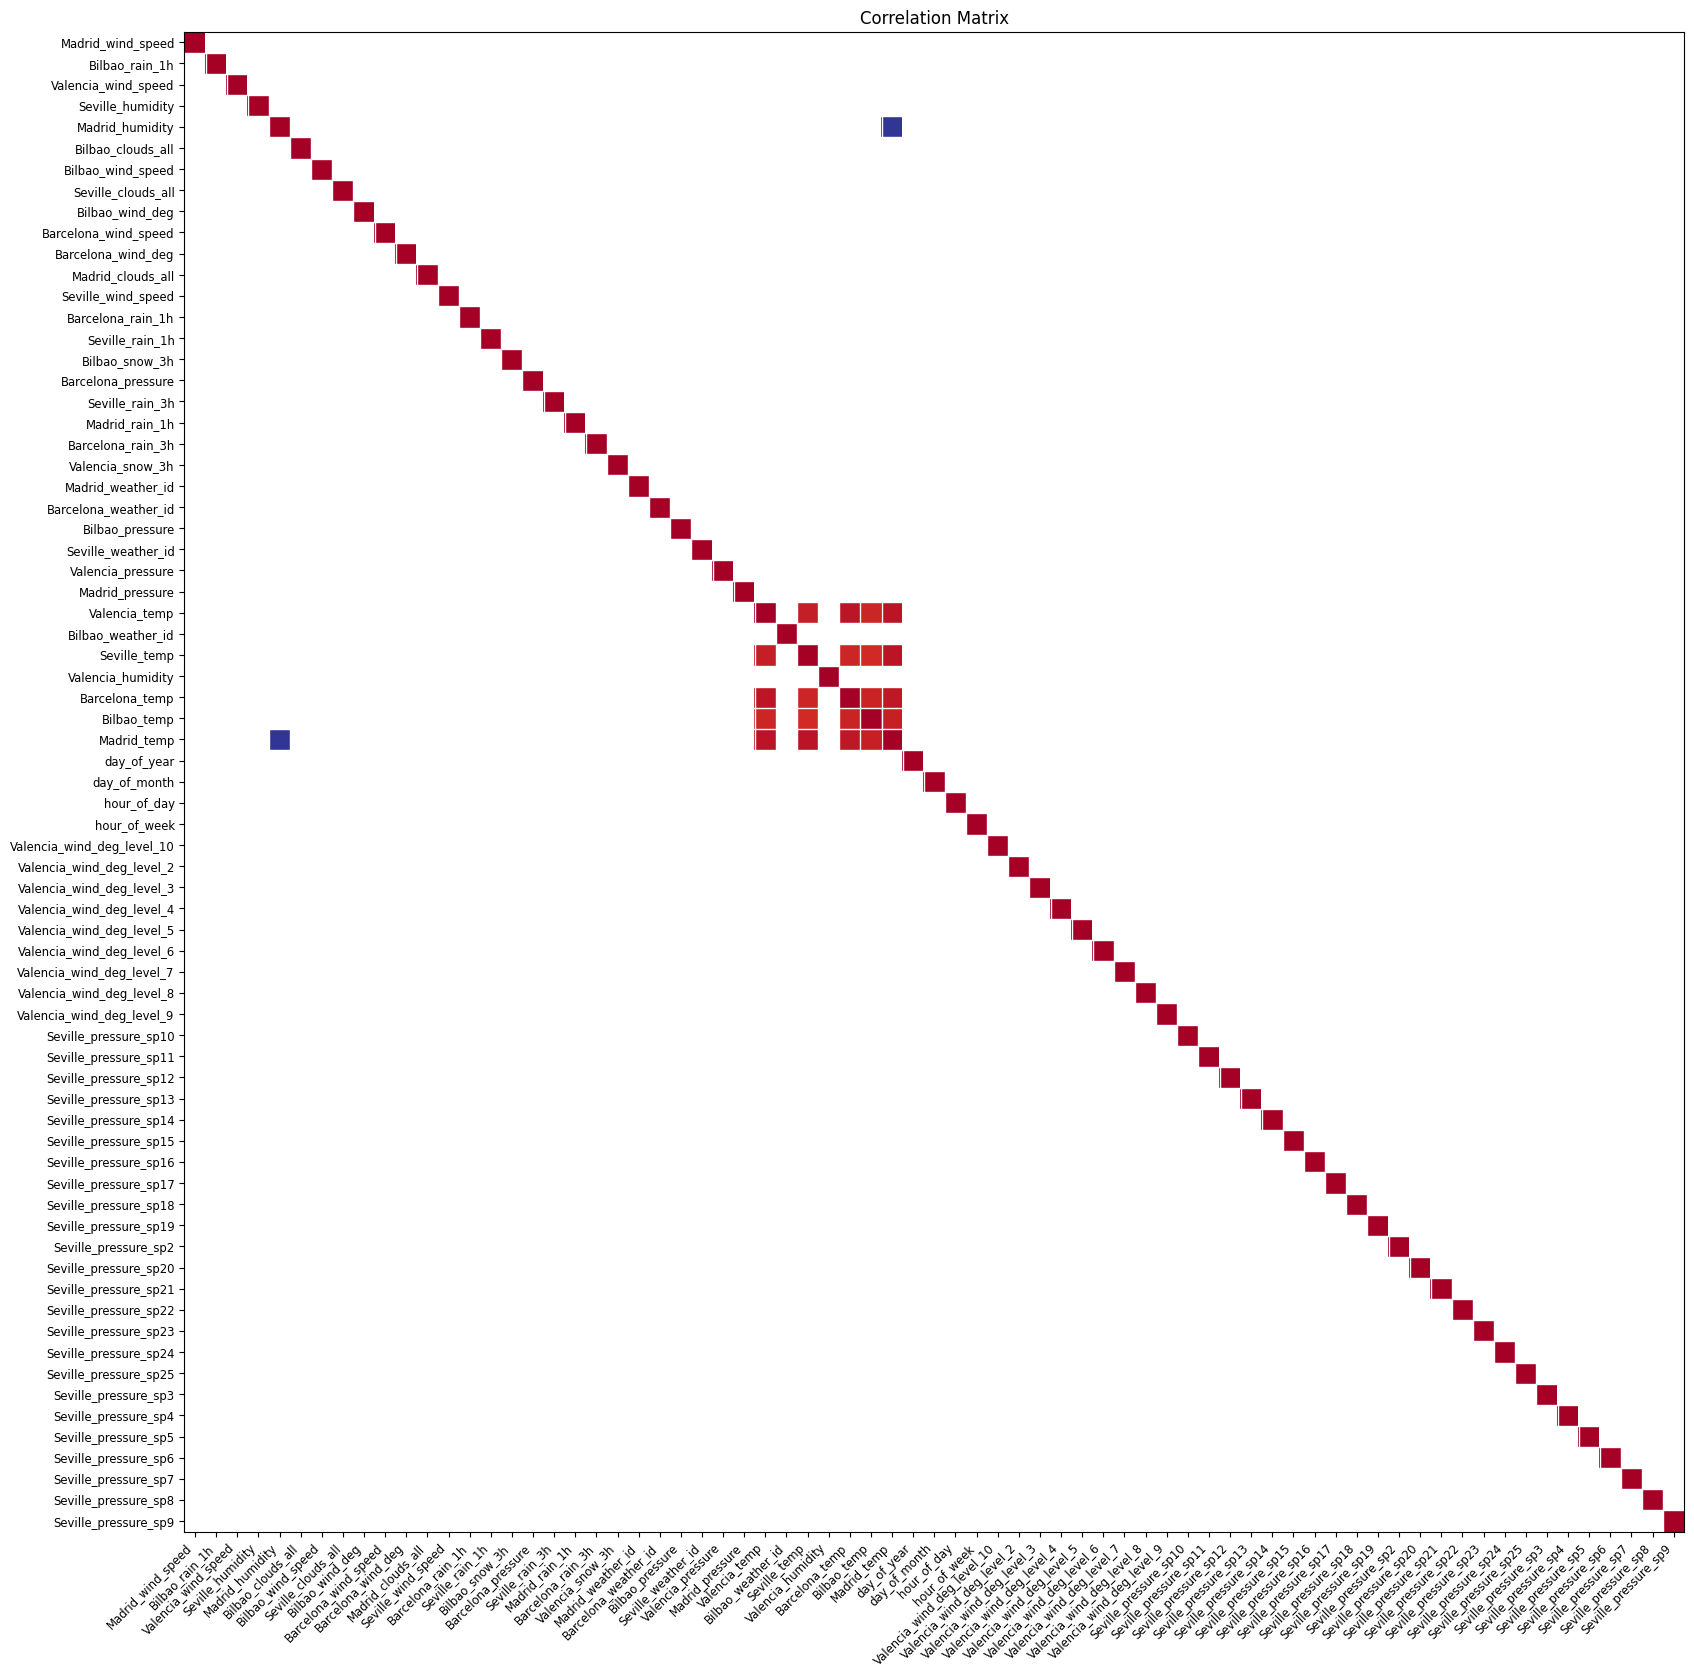

In [39]:
fig = plt.figure(figsize=(17,17));
ax = fig.add_subplot(111);
plot_corr(df.corr()[np.abs(df.corr()) > 0.8], xnames = df.corr().columns, ax = ax);

In [40]:
df.shape

(8763, 71)

Our features have reduced to 71 excluding the target variable.

Let's have a look at the last dataframe

In [41]:
df.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,...,Seville_pressure_sp23,Seville_pressure_sp24,Seville_pressure_sp25,Seville_pressure_sp3,Seville_pressure_sp4,Seville_pressure_sp5,Seville_pressure_sp6,Seville_pressure_sp7,Seville_pressure_sp8,Seville_pressure_sp9
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,0.630823,1.932284,...,False,False,True,False,False,False,False,False,False,False
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.607959,0.630270,...,False,False,True,False,False,False,False,False,False,False
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,0.542632,-0.485743,...,False,False,True,False,False,False,False,False,False,False
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,0.398912,-0.299741,...,False,False,True,False,False,False,False,False,False,False
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.255192,0.816272,...,False,False,True,False,False,False,False,False,False,False


## Feature engineering on test dataframe

In [42]:
#copy the test df to a new df
test_df = df_test.copy()

In [43]:
# Convert time to Datetime
test_df['time'] = pd.to_datetime(test_df['time'])

Let's create temporal features

In [44]:
test_df['day_of_year'] = test_df['time'].dt.dayofyear
test_df['day_of_month'] = pd.DatetimeIndex(test_df['time']).day                            
test_df['hour_of_day'] = pd.DatetimeIndex(test_df['time']).hour                            
test_df['hour_of_week'] = (test_df['time'].dt.dayofweek ) * 24 +  test_df['time'].dt.hour  

In [45]:
test_df.head()

,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,...,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,day_of_year,day_of_month,hour_of_day,hour_of_week
8763,2018-01-01 00:00:00,5.000000,level_8,0.0,5.000000,87.000000,71.333333,20.000000,3.000000,0.000000,...,280.380000,286.816667,285.150000,283.150000,279.866667,279.150000,1,1,0,0
8764,2018-01-01 03:00:00,4.666667,level_8,0.0,5.333333,89.000000,78.000000,0.000000,3.666667,0.000000,...,281.010000,283.483333,284.150000,281.150000,279.193333,278.150000,1,1,3,3
8765,2018-01-01 06:00:00,2.333333,level_7,0.0,5.000000,89.000000,89.666667,0.000000,2.333333,6.666667,...,279.196667,281.816667,282.150000,280.483333,276.340000,276.150000,1,1,6,6
8766,2018-01-01 09:00:00,2.666667,level_7,0.0,5.333333,93.333333,82.666667,26.666667,5.666667,6.666667,...,281.740000,282.150000,284.483333,279.150000,275.953333,274.483333,1,1,9,9
8767,2018-01-01 12:00:00,4.000000,level_7,0.0,8.666667,65.333333,64.000000,26.666667,10.666667,0.000000,...,284.116667,286.150000,286.816667,284.483333,280.686667,280.150000,1,1,12,12


In [46]:
test_time = test_df[['time']]

# Needs Reindex the test data
test_time = test_time.reset_index().drop(["index"], axis=1)
test_time

,time
0,2018-01-01 00:00:00
1,2018-01-01 03:00:00
2,2018-01-01 06:00:00
3,2018-01-01 09:00:00
4,2018-01-01 12:00:00
...,...
2915,2018-12-31 09:00:00
2916,2018-12-31 12:00:00
2917,2018-12-31 15:00:00
2918,2018-12-31 18:00:00


In [47]:
#drop categorical columns 
test_df = test_df.drop(['time', 'Valencia_wind_deg', 'Seville_pressure' ], axis=1)

In [48]:
#sacling the dataFrame using the StandarScalar
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns = test_df.columns)

In [49]:
#Imputing the missing values using Knn Imputer
test_df = pd.DataFrame(imputer.fit_transform(test_df), columns = test_df.columns)

In [50]:
#creating dummies for test categorical variables
cat_var = df_test[['Valencia_wind_deg', 'Seville_pressure']]
test_dummies = pd.get_dummies(cat_var, drop_first=True)
test_dummies.head()

,Valencia_wind_deg_level_10,Valencia_wind_deg_level_2,Valencia_wind_deg_level_3,Valencia_wind_deg_level_4,Valencia_wind_deg_level_5,Valencia_wind_deg_level_6,Valencia_wind_deg_level_7,Valencia_wind_deg_level_8,Valencia_wind_deg_level_9,Seville_pressure_sp10,...,Seville_pressure_sp23,Seville_pressure_sp24,Seville_pressure_sp25,Seville_pressure_sp3,Seville_pressure_sp4,Seville_pressure_sp5,Seville_pressure_sp6,Seville_pressure_sp7,Seville_pressure_sp8,Seville_pressure_sp9
8763,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
8764,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
8765,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8766,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8767,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [51]:
# Drop all temp_max and temp_min for all the cities to avoid multicollinearity
test_df = test_df.drop(['Seville_temp_max','Valencia_temp_max','Barcelona_temp_max','Madrid_temp_max','Bilbao_temp_max','Seville_temp_min','Valencia_temp_min','Barcelona_temp_min','Madrid_temp_min','Bilbao_temp_min'],axis=1)

Train and test data have been cleaned and we have performed feature engineering. Let's get into modelling.

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section we create models that will predict the 3 hour load shortfall.

In [52]:
# create targets and features dataset
X = df
y = target

In [53]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state= 42)

In [54]:
#checking the shape of the training and testing sets to make sure they align
print('Training predictor:', X_train.shape)
print('Training target:', y_train.shape)
print('Testing predictor:', X_test.shape)
print('Testing target:', y_test.shape)

Training predictor: (7010, 71)
Training target: (7010,)
Testing predictor: (1753, 71)
Testing target: (1753,)


### Linear regression

In [55]:
#Instantiate the model using sklearn
lr = LinearRegression()

#Fit the model into training set
lr.fit(X_train, y_train)

#predict on unseen data
predict = lr.predict(X_test)
#predicting on the same training set
train_predict = lr.predict(X_train)

### Decision Trees

In [56]:
# Instantiate regression tree model using sklearn
Reg_tree = DecisionTreeRegressor(random_state=42)

# Fitting the model
Reg_tree.fit(X_train,y_train)

Tree_pred = Reg_tree.predict(X_test)

### Random Forest

In [57]:
# This forest consists of 200 trees with a max depth of 8, we use sklearn to apply the model 
RF = RandomForestRegressor(n_estimators=200, max_depth=8)

# Fitting the model
RF.fit(X_train,y_train)

RF_predict = RF.predict(X_test)

### Xgboost

In [58]:
Xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.1,
                max_depth = 5, alpha = 6, n_estimators = 100, subsample = 0.7) 

'''
reg:squaredlogerror objective. 
This metric reduces errors generated 
by outliers in dataset. from sklearn
'''
# Fitting the model
Xg_reg.fit(X_train, y_train)

Xg_predict = Xg_reg.predict(X_test)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

To identify any inaccurate predictions, such as drift in detection, bias, or increased data inconsistency, performance must be evaluated.

In [59]:
# Compare model performance
#Comparing the True value and the Predicted Value of our models by putting them beside one another
Linear = pd.DataFrame({'Actual': y_test, 'Predicted': predict})
Des_ = pd.DataFrame({'Actual': y_test, 'Predicted': Tree_pred})
Rand_ = pd.DataFrame({'Actual': y_test, 'Predicted': RF_predict})
Xg_ = pd.DataFrame({'Actual': y_test, 'Predicted': RF_predict})
print("Linear regression:")
print(Linear.head()) #Linear Model 
print('\n')
print("Decision tree:")
print(Des_.head()) #Decision Tree Model
print('\n')
print("Random forest:")
print(Rand_.head()) # Random Forest Model
print('\n')
print("XgBoost:")
print(Xg_.head()) # Xg Boost Model

Linear regression:
            Actual     Predicted
7010  16075.333333  11300.987287
7011  15722.666667  10340.413171
7012  12181.666667  10522.719395
7013  10992.666667  10688.415768
7014  11060.000000  10880.311966


Decision tree:
            Actual     Predicted
7010  16075.333333  11341.333333
7011  15722.666667  12281.000000
7012  12181.666667  10577.000000
7013  10992.666667  10498.000000
7014  11060.000000  11034.333333


Random forest:
            Actual     Predicted
7010  16075.333333  10213.446237
7011  15722.666667  11165.325347
7012  12181.666667   8181.173406
7013  10992.666667   8430.412476
7014  11060.000000   7995.741402


XgBoost:
            Actual     Predicted
7010  16075.333333  10213.446237
7011  15722.666667  11165.325347
7012  12181.666667   8181.173406
7013  10992.666667   8430.412476
7014  11060.000000   7995.741402


### Root Mean Square Error (RMSE)

The RMSE is a metric we use to measure a model's prediction accuracy. It measures the difference between the predicted values and actual values. It is widely used because it accounts for outliers while easy to interprete. The lower the RMSE, the better the model fits the data or the more accurate the prediction.

In [61]:
Model_Performance = { 
    
                      'RMSE':
                    
                        {"Linear regression": np.sqrt(metrics.mean_squared_error(y_test,predict)),
                        "Decision tree" : np.sqrt(metrics.mean_squared_error(y_test,Tree_pred)),
                        "Random forest" : np.sqrt(metrics.mean_squared_error(y_test,RF_predict)),
                        "XgBoost" : np.sqrt(metrics.mean_squared_error(y_test,Xg_predict))}
                        
                    }

# create dataframe from dictionary
Model_Performance = pd.DataFrame(data=Model_Performance)
Model_Performance

,RMSE
Linear regression,4804.609833
Decision tree,5071.196732
Random forest,4261.257076
XgBoost,3742.405693


Now that we have evaluated the performance, it is clear that XgBoost gives the lowest RMSE hence the most accurate

<a id="six"></a>
## 6. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

We conducted a comprehensive exploratory analysis to gain a deep understanding of the dataset. Following this, we split the data into training and test sets. This allowed us to clean the data and engineer necessary features, addressing outliers and downsampling time where needed.

### Model Training and Optimization
We trained four different models using the following algorithms:

- Linear Regression
- Decision Trees
- Random Forest
- XgBoost

We optimized these models to ensure the best possible performance. After evaluating the model performance, we found that the XgBoost algorithm produced the best results, demonstrating robustness against overfitting and achieving the lowest Root Mean Squared Error (RMSE).

### Project Aim
The primary aim of this project is to assist the Spanish government in understanding the patterns and trends in energy production, both renewable and fossil fuel. This understanding can guide policy decisions regarding infrastructure investments in the energy sector.

### Recommendations
Based on the predictions and analysis, we recommend the following alternative energy resources:

- Geothermal: Spain's high geothermal temperatures make this a viable and successful energy source.
- Solar: Spain's hot and dry climate, characterized by minimal rainfall and snowfall, is highly conducive to solar power generation.
- Nuclear and Biomass: These sources are viable options as they are unaffected by weather conditions.
- However, we do not recommend wind power as a feasible option due to insufficient wind speeds (below the required 12 km/h) for efficient energy generation.

In conclusion, our model not only predicts short-term load shortfalls but also provides valuable insights into the feasibility of various energy sources, thereby supporting informed policy-making for Spain's energy sector.